In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl

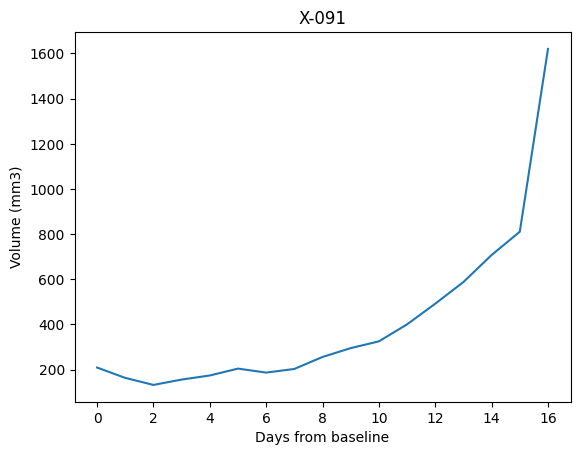

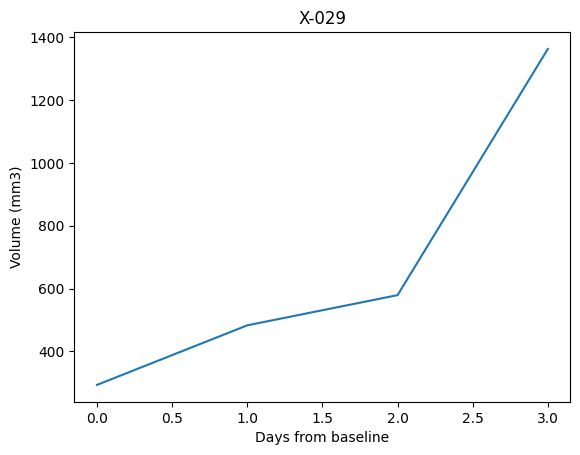

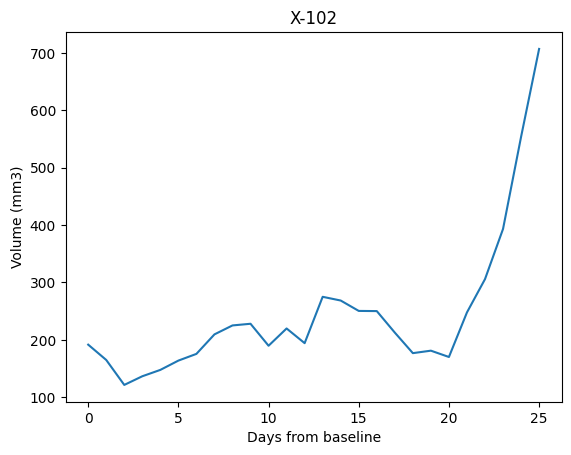

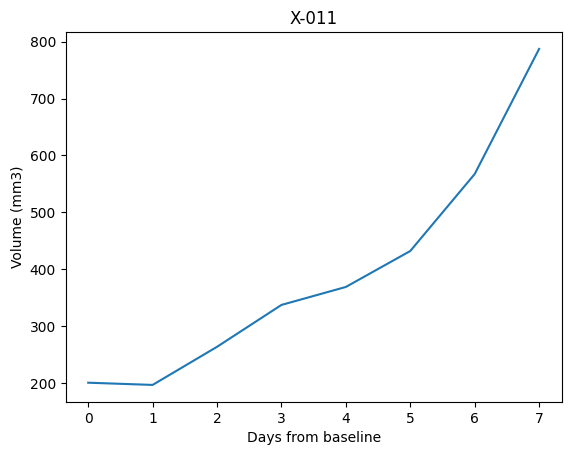

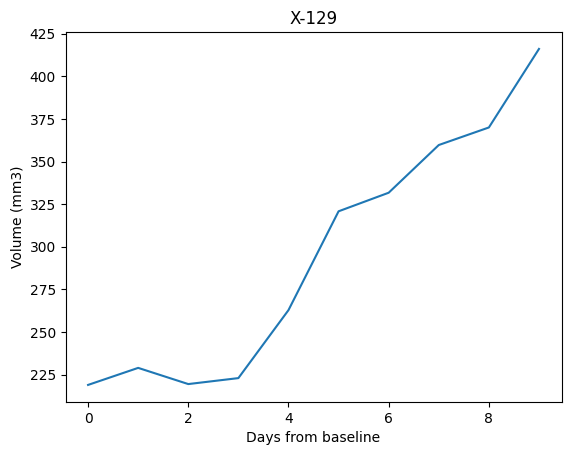

In [23]:
data = pl.read_excel("../41591_2015_BFnm3954_MOESM10_ESM.xlsx", sheet_name="PCT raw data")

# choosing a single combination of Tumor Type and Treatment
data2 = (data.filter(pl.col("Tumor Type") == "GC")).filter(pl.col("Treatment") == "BGJ398")

# see how different models progress over time under the same treatment
for i, model in enumerate(data2['Model'].unique()):
    if i < 5:
        data3 = data2.filter(pl.col('Model') == model)
        plt.plot(data3['Volume (mm3)'])
        # plt.title(f'Model: {model}, Treatment: BGJ398, Tumor Type: GC')
        plt.title(model)
        plt.xlabel('Days from baseline')
        plt.ylabel('Volume (mm3)')
        plt.show()
    else:
        break

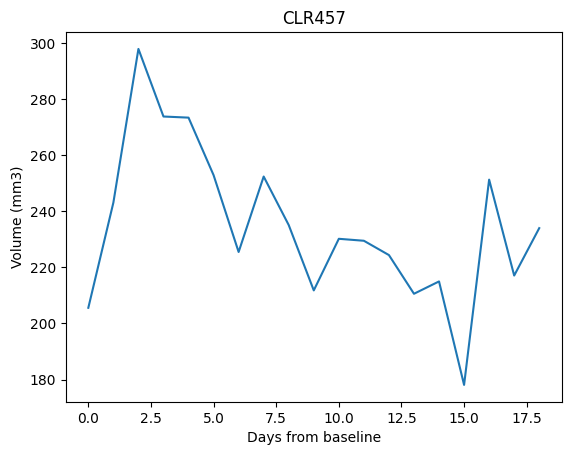

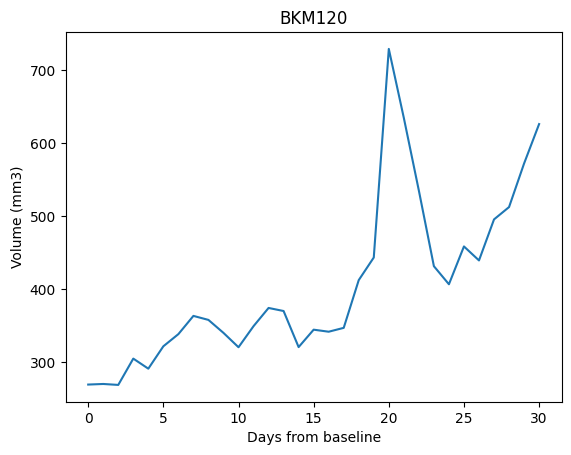

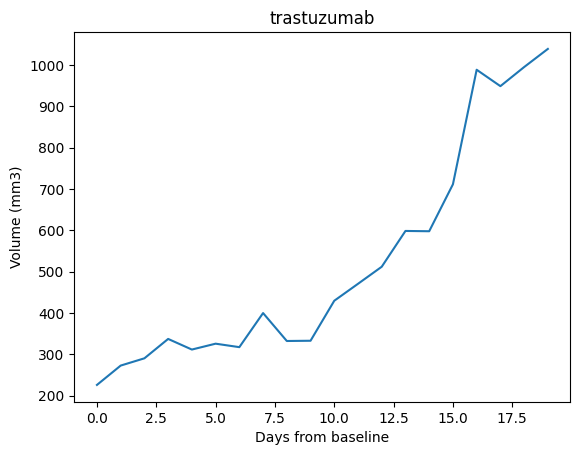

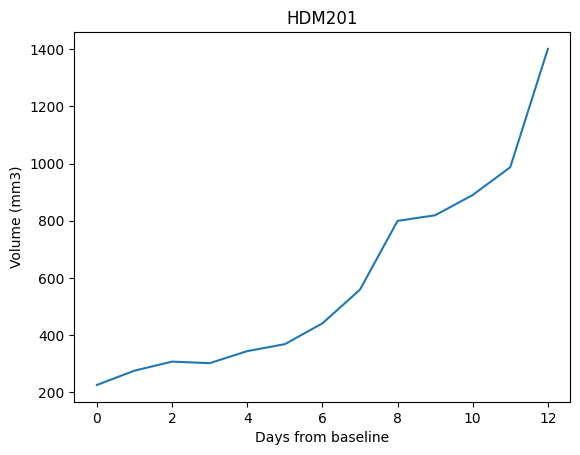

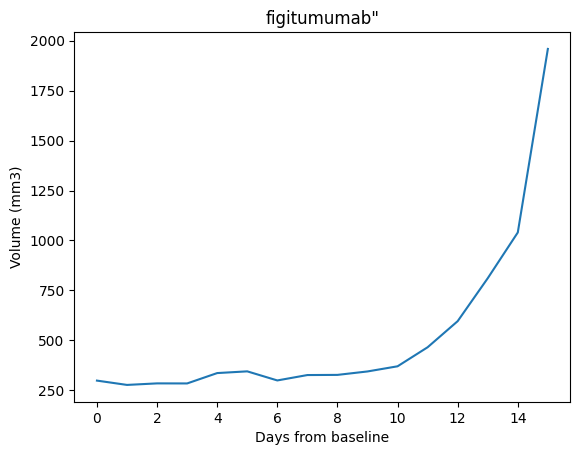

In [25]:
# data = pl.read_excel("../41591_2015_BFnm3954_MOESM10_ESM.xlsx", sheet_name="PCT raw data")

# choosing a single combination of Tumor Type and Model
data2 = (data.filter(pl.col("Tumor Type") == "GC")).filter(pl.col("Model") == "X-091")

# see how different treatments progress over time for the same tumor type
for i, treatment in enumerate(data2['Treatment'].unique()):
    if i < 5:
        data3 = data2.filter(pl.col('Treatment') == treatment)
        plt.plot(data3['Volume (mm3)'])
        # plt.title(f'Model: {model}, Treatment: BGJ398, Tumor Type: GC')
        plt.title(treatment)
        plt.xlabel('Days from baseline')
        plt.ylabel('Volume (mm3)')
        plt.show()
    else:
        break

In [9]:
data3 = data2.filter(pl.col('Model') == 'X-077')
    
from hmmlearn import hmm

# Set up the initial transition matrix with the known constraint
transmat_prior = np.array([[0.5, 0.5],
                           [0.0, 1.0]])

# Create an HMM with Gaussian emissions and two hidden states
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, init_params='smc')
model.transmat_ = transmat_prior

# Fit the model to the data
model.fit(data3['Volume (mm3)'].to_numpy().reshape(-1, 1))

# Predict the hidden states
hidden_states_predicted = model.predict(data3['Volume (mm3)'].to_numpy().reshape(-1, 1))
hidden_states_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [28]:
data3 = data2.filter(pl.col('Treatment') == "HDM201")
    
from hmmlearn import hmm

# Set up the initial transition matrix with the known constraint
transmat_prior = np.array([[0.5, 0.5],
                           [0.0, 1.0]])

# Create an HMM with Gaussian emissions and two hidden states
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000, init_params='smc')
model.transmat_ = transmat_prior

# Fit the model to the data
model.fit(data3['Volume (mm3)'].to_numpy().reshape(-1, 1))

# Predict the hidden states
hidden_states_predicted = model.predict(data3['Volume (mm3)'].to_numpy().reshape(-1, 1))
hidden_states_predicted

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

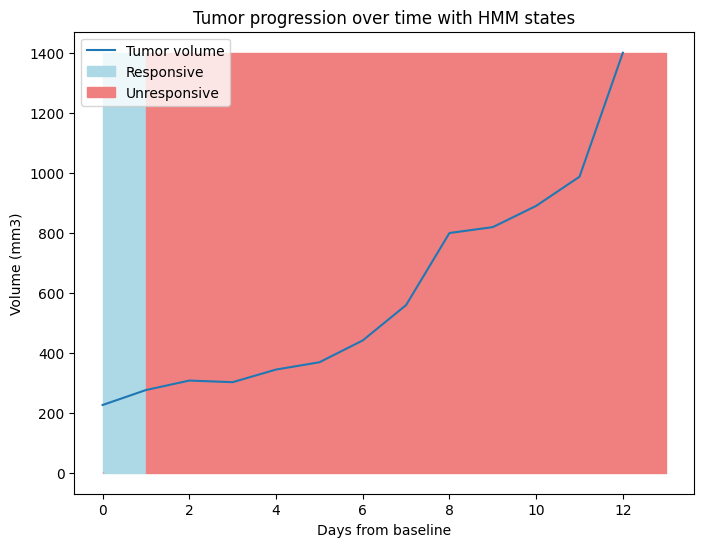

In [29]:
# Plot the progression over time

plt.figure(figsize=(8, 6))
plt.plot(data3['Volume (mm3)'], label="Tumor volume")

# Fill regions based on the hidden states
days = np.arange(len(data3['Volume (mm3)']))
for i, state in enumerate(hidden_states_predicted):
    if state == 0:
        plt.fill_between([i, i+1], 0, max(data3['Volume (mm3)']), color='lightblue')
    else:
        plt.fill_between([i, i+1], 0, max(data3['Volume (mm3)']), color='lightcoral')

# Dummy fills for the legend
plt.fill_between([0, 0], 0, 1, color='lightblue', label='Responsive')
plt.fill_between([0, 0], 0, 1, color='lightcoral', label='Unresponsive')

plt.title("Tumor progression over time with HMM states")
plt.xlabel('Days from baseline')
plt.ylabel('Volume (mm3)')
plt.legend()
plt.show()


After we get the hidden states of each time point using the HMM, we then create a separate autoregressive model for both the responsive and unresponsive states. For the autoregressive model, I am just using a simple autoregressive model with lag one (the value at time $t$ only depends on the immediate previous value).

$$y_t = \mu + \phi y_{t-1} + \epsilon_t$$

For this, to start off, I am using a non probabilistic model from `statsmodel`. After this, we use MCMC sampler with a normal likelihood to get variance in our predictions. For now, I'm just doing it for the state where it's unresponsive.

In [32]:
from statsmodels.tsa.ar_model import AutoReg

# Split the data based on the predicted hidden states
data_state1 = data3['Volume (mm3)'].to_numpy()[hidden_states_predicted == 1]  # unresponsive
data_state0 = data3['Volume (mm3)'].to_numpy()[hidden_states_predicted == 0]

# Fit an autoregressive model to each subset
ar_model_state1 = AutoReg(data_state1, lags=1).fit()
# ar_model_state0 = AutoReg(data_state0, lags=1).fit()

# see the results -- the coefficients of the AR model
print(f'mu: {ar_model_state1.params[0]}\nphi: {ar_model_state1.params[1]}')


mu: -40.563928072010825
phi: 1.2578480233648028


After this, I get the predicted data from the autoregressive model for the unresponsive state and plot it on top of the actual data to see the difference

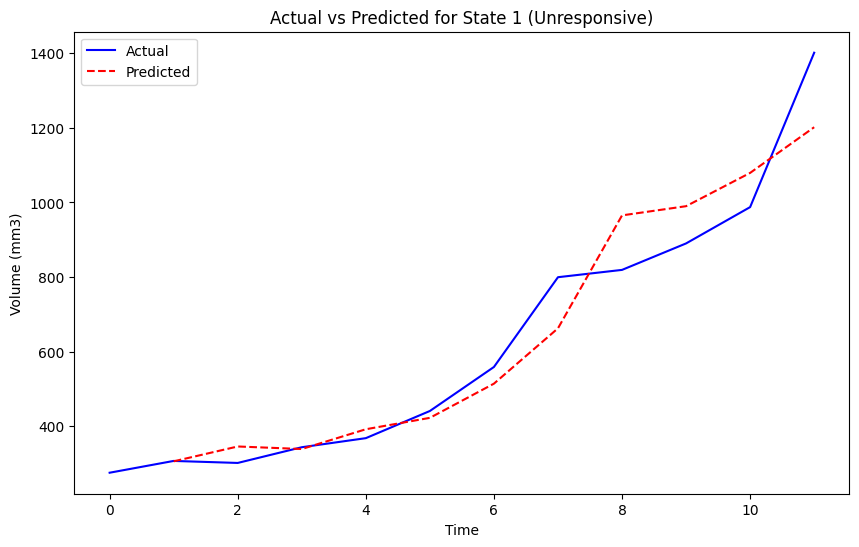

In [33]:
# Get the predicted values
predicted_data = ar_model_state1.predict(start=1, end=len(data_state1)-1, dynamic=False)

# Create the adjusted time indices for the predicted data
predicted_indices = np.arange(1, len(data_state1))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(data_state1, label='Actual', color='blue')
plt.plot(predicted_indices, predicted_data, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted for State 1 (Unresponsive)')
plt.xlabel('Time')
plt.ylabel('Volume (mm3)')
plt.legend()
plt.show()


I then used a probabilistic approach to this and used `Pyro`'s SVI algorithm to see if the results are close to the ones from `statsmodel`. But the results were very different

In [75]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal


def ar1_model(data_state1):
    y_t_minus_1 = data_state1[:-1]
    
    # Prior distributions
    phi = pyro.sample('phi', dist.Normal(0, 10))
    mu = pyro.sample('mu', dist.Normal(0, 10))
    sigma = pyro.sample('sigma', dist.HalfNormal(10))
    
    # Likelihood
    with pyro.plate('observed_data', len(data_state1) - 1):
        pyro.sample('y_t', dist.Normal(mu + phi * y_t_minus_1, sigma), obs=data_state1[1:])

# Use an AutoGuide
guide = AutoDiagonalNormal(ar1_model)

# Convert data_state1 to torch tensor
data_state1_torch = torch.tensor(data_state1, dtype=torch.float32)

pyro.clear_param_store()
svi = SVI(model=ar1_model, guide=guide, optim=Adam({"lr": 0.001}), loss=Trace_ELBO())

for step in range(20000):
    svi.step(data_state1_torch)
    if step % 2000 == 0:
        print(f"Step {step}, ELBO: {svi.evaluate_loss(data_state1_torch)}")

# Extract samples
phi_samples = pyro.param('AutoDiagonalNormal.loc')[0].item()
mu_samples = pyro.param('AutoDiagonalNormal.loc')[1].item()
sigma_samples = pyro.param('AutoDiagonalNormal.scale')[2].exp().item()

print(f"Phi: {phi_samples}, Mu: {mu_samples}, Sigma: {sigma_samples}")

Step 0, ELBO: 2571997.454886794
Step 2000, ELBO: 154480.0134651661
Step 4000, ELBO: 33444.50749516487
Step 6000, ELBO: 5549.4285707473755
Step 8000, ELBO: 2301.350330591202
Step 10000, ELBO: 489.5476620197296
Step 12000, ELBO: 157.57962131500244
Step 14000, ELBO: 100.90142297744751
Step 16000, ELBO: 93.8153989315033
Step 18000, ELBO: 93.61584329605103
Phi: 1.1882606744766235, Mu: 6.0457892417907715, Sigma: 1.0787405967712402


I also tried `Pyro`'s MCMC algorithms but I had problems running it. It had problems running the multiple chains, so I just run it with a single chain.

In [58]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# Convert data to PyTorch tensor
data_state1_torch = torch.tensor(data_state1, dtype=torch.float32)

def ar1_model_1():
    # create a probabilistic autoregressive model with lag one for the first state (state 0)
    phi = pyro.sample('phi', dist.Normal(0, 10))
    mu = pyro.sample('mu', dist.Normal(0, 10))
    sigma = pyro.sample('sigma', dist.HalfNormal(10))
    
    # likelihood
    with pyro.plate("data", len(data_state1)-1):
        pyro.sample('y_t', dist.Normal(mu + phi * data_state1_torch[:-1], sigma), obs=data_state1_torch[1:])

nuts_kernel = NUTS(ar1_model_1)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1000, num_chains=1)
mcmc.run()
mcmc.summary()

Sample: 100%|██████████| 2000/2000 [00:16, 121.16it/s, step size=7.81e-01, acc. prob=0.877]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -2.00      9.36     -1.83    -18.68     11.40    635.75      1.00
       phi      1.20      0.03      1.20      1.15      1.25    702.43      1.01
     sigma     53.43      4.79     53.05     45.21     60.69    934.47      1.00

Number of divergences: 0


Because I couln't run multiple chains, I used `PyMC` instead to see if the sampler is actually working okay

/Users/hussen/anaconda3/envs/pyro-env/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


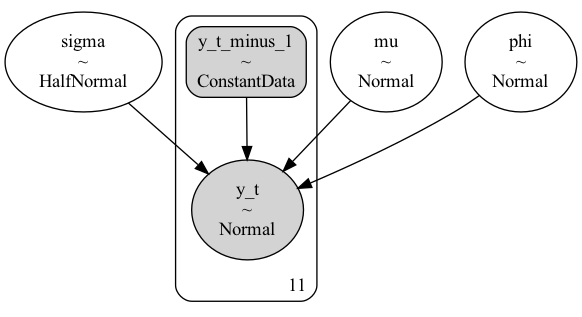

In [59]:
import pymc as pm
import arviz as az

with pm.Model() as ar1_model_1:
    # create a probabilistic autoregressive model with lag one for the state 1 (unresponsive)
    phi = pm.Normal('phi', mu=0, sigma=10)
    mu = pm.Normal('mu', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=10)
    y_t_minus_1 = pm.Data('y_t_minus_1', data_state1[:-1])
    
    # likelihood
    y_t = pm.Normal('y_t', mu=mu + phi*y_t_minus_1, sigma=sigma, observed=data_state1[1:])
    

from IPython.display import Image 
Image(pm.model_to_graphviz(ar1_model_1).render(format='png'))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [phi, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,1.20,0.03,1.15,1.26,0.00,0.00,3264.41,3233.32,1.0
mu,-2.97,9.71,-20.32,15.09,0.17,0.13,3128.81,3162.15,1.0
sigma,53.59,4.59,44.93,62.04,0.08,0.06,3347.67,2843.85,1.0


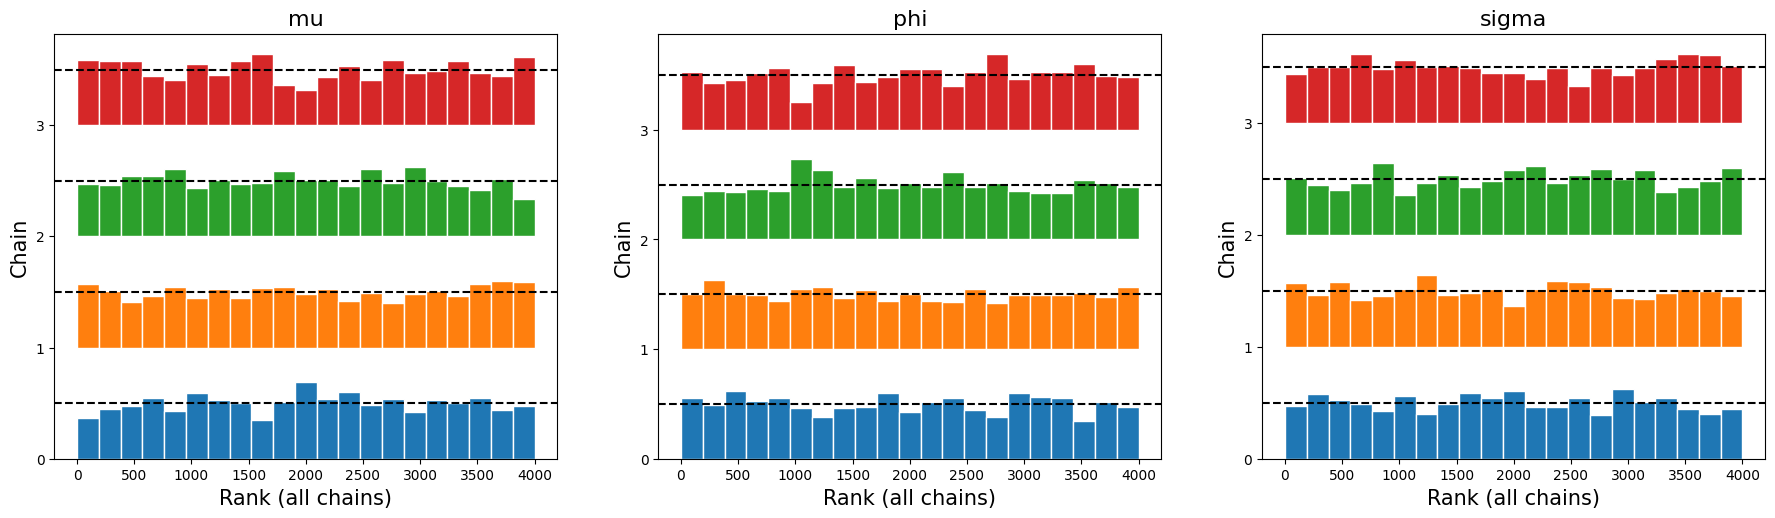

In [62]:
# inference
with ar1_model_1:
    trace_1 = pm.sample(1000, tune=1000, chains=4, cores=1)

display(az.summary(trace_1, round_to=2))
az.plot_rank(trace_1, var_names=['mu', 'phi', 'sigma'])  # to see how the chains behave -- to make sure that our sampler is working well
plt.show()

Sampling: [y_t]


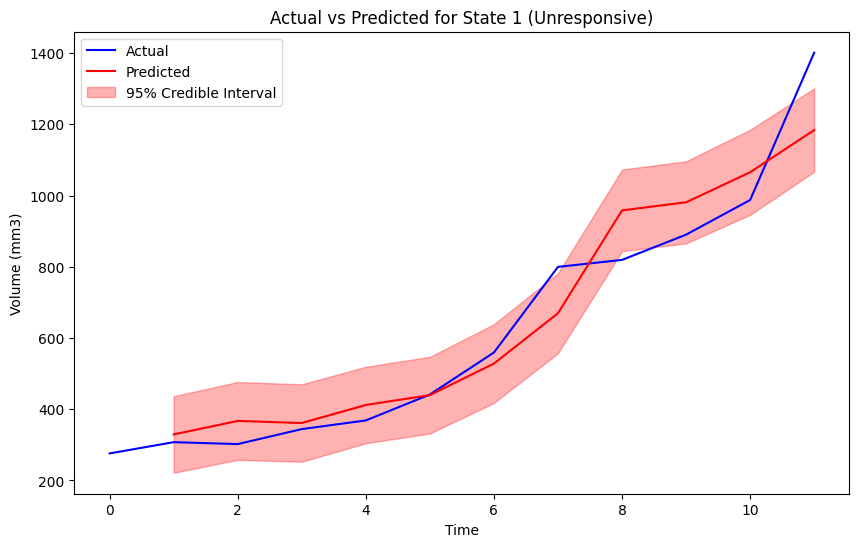

In [73]:
# Generate posterior predictive samples
with ar1_model_1:
    posterior_predictive = pm.sample_posterior_predictive(trace_1, var_names=['y_t'])

# Compute the mean and standard deviation of the posterior predictive samples
ppc_samples = posterior_predictive.posterior_predictive.y_t.values
ppc_mean = np.mean(ppc_samples, axis=(0, 1))
ppc_std = np.std(ppc_samples, axis=(0, 1))


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data_state1, label='Actual', color='blue')
plt.plot(np.arange(1, len(data_state1)), ppc_mean, label='Predicted', color='red')
plt.fill_between(np.arange(1, len(data_state1)), ppc_mean - 2*ppc_std, ppc_mean + 2*ppc_std, color='red', alpha=0.3, label='95% Credible Interval')
plt.title('Actual vs Predicted for State 1 (Unresponsive)')
plt.xlabel('Time')
plt.ylabel('Volume (mm3)')
plt.legend()
plt.show()


### This is not the most polished thing, but I just wanted to get started on it and get some feedback. I would like to continue working on this and iterate on it as the project continues